In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

##data processing
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.stem import SnowballStemmer

from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer,TfidfTransformer

##machine learning modles
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier


import os
import warnings
warnings.simplefilter(action = 'ignore', category=FutureWarning)
warnings.filterwarnings('ignore')
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)

## Load Data

The data source is an online Movie Sentiment project.  
In trainning data, there is Phrase column and Sentiment column as the result score from 0 to 4 (negative to positve); 
In test data, there is Phrase column for us to analyze the sentiment of each phrase.

In [2]:
train = pd.read_csv('C:/Users/Jiayi/OneDrive - ucsc.edu/python/project/movie_reviews/train.tsv.zip',sep="\t") 
test = pd.read_csv('C:/Users/Jiayi/OneDrive - ucsc.edu/python/project/movie_reviews/test.tsv.zip',sep="\t") 


In [3]:
train.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156060 entries, 0 to 156059
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   PhraseId    156060 non-null  int64 
 1   SentenceId  156060 non-null  int64 
 2   Phrase      156060 non-null  object
 3   Sentiment   156060 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 4.8+ MB


## Data Visualization: Distribution of sentiment class

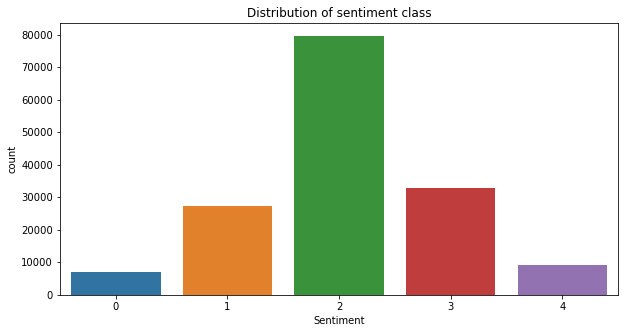

In [5]:
## Show the number of class distributed
plt.figure(figsize=(10,5))
ax=plt.axes()
ax.set_title('Distribution of sentiment class')
sns.countplot(x=train.Sentiment,data=train)

##### The sentiment labels are:

0 - negative
1 - somewhat negative
2 - neutral
3 - somewhat positive
4 - positive

## Data Visualization: Keywords by sentiment class

In [6]:
 #!pip install wordcloud
from wordcloud import WordCloud,STOPWORDS
def vis(dataset,i):
    data=dataset[dataset['Sentiment']==i]
    words = ' '.join(data["Phrase"])
    split_word = " ".join([word for word in words.split()])
    wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='black',
                      width=3000,
                      height=2500
                     ).generate(split_word)
    plt.figure(i,figsize=(7, 7))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.title('Sentiment Class {}'.format(i))
    plt.show()



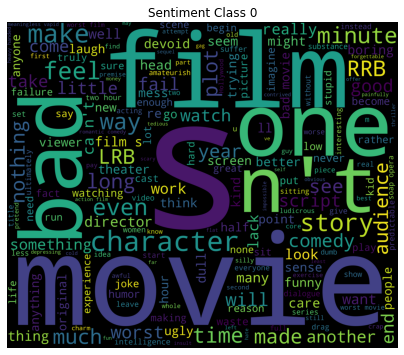

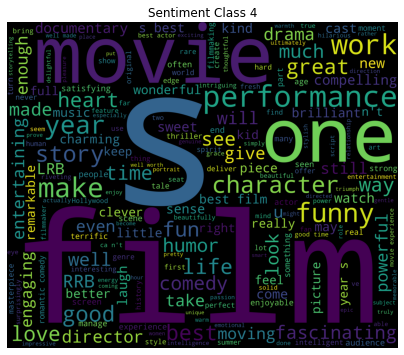

In [7]:
vis(train,0)    
#vis(train,1)
#vis(train,2)
#vis(train,3)
vis(train,4)

## NLP Preprocess Function

In [8]:

## Preprocess function
stopwords_e=stopwords.words('english')
snow=SnowballStemmer('english')
def data_preprocess(text):
    text_nonpunc=[w.lower() for w in text if w not in string.punctuation]
    text_nonpunc=''.join(text_nonpunc)
    text_rmstop=[x for x in text_nonpunc.split(' ') if x not in stopwords_e]
    text_stem=[snow.stem(w) for w in text_rmstop]
    text1=' '.join(text_stem)
    return (text1)

In [9]:
vector=TfidfVectorizer(stop_words='english')   

## ML Model Functions (OOP)

In [10]:
class EstimatorSelection:
    
    def __init__(self, models):
        self.models=models
        self.keys=models.keys()
        self.results={}
        self.modelfit={}
        self.modelpredict={}
        
    def fit(self, x, y):
        x1=x.apply(lambda i: data_preprocess(i))
        x_feature1=vector.fit_transform(x1)
        for key in self.keys:
            model=self.models[key]
            self.modelfit[key]=model.fit(x_feature1,y)
            y_pred=model.predict(x_feature1)
            self.results[key]=classification_report(y, y_pred,output_dict=True)
    
    def predict(self,test_x):
        test_x1=test_x.apply(lambda i: data_preprocess(i))
        test_feature1=vector.transform(test_x1)
        test_frames=[]
        for key in self.keys:
            modelfit=self.modelfit[key]
            test_y=modelfit.predict(test_feature1)
            test_frame=pd.DataFrame(test_y,columns=[key])
            test_frames.append(test_frame)
        predict_frame=pd.concat(test_frames,axis=1)            
        return(predict_frame)     
    
    def summary(self):
        Frames=[]
        for key in self.keys:
            result=self.results[key]
            Frame=pd.DataFrame(result['macro avg'], index=[key])
            Frames.append(Frame)
        result_sum=pd.concat(Frames)
        return result_sum.iloc[:,:3]



In [11]:
models = { 
    'LogisticClassifier': LogisticRegression(multi_class='ovr'),
    'RandomforestClassifier':RandomForestClassifier(random_state=101),
    'Support Vector Machines':svm.SVC(decision_function_shape='ovo')
}

In [12]:
model_compare=EstimatorSelection(models)

In [ ]:
model_compare.fit(train["Phrase"], train["Sentiment"])

## Compare Model Performances

In [ ]:
summary=model_compare.summary()
summary

## Compare Model Predict Results

In [ ]:
predict_result=model_compare.predict(test["Phrase"])
predict_result1=predict_result.reset_index().rename(columns={'index':'case'})
predict_result2=pd.melt(predict_result1,id_vars='case', value_vars=['LogisticClassifier', 'RandomforestClassifier', 'Support Vector Machines'])

predict_result3=predict_result2.groupby(['variable','value']).size().reset_index().rename(columns={0:'count'})

predict_result3

In [ ]:
plt.figure(figsize=(10,5))
ax=plt.axes()
ax.set_title('Number of class for each methods')
sns.barplot(x='value', y='count', hue='variable', data=predict_result3)

## Get the Final results from the mode

In [ ]:
Final_results=[]
for i in range(predict_result1.shape[0]):
    Final_result=stats.mode(predict_result1.iloc[i,]).mode.item()
    Final_results.append(Final_result)
    
predict_result1['Final_result']=Final_results
predict_result1    

In [ ]:
test['Sentiment']=Final_results
test

In [ ]:
# NLP: Process Text Data
# remove punctuation and lowercase
#import string
#from nltk.corpus import stopwords
#import nltk
#train["Phrase"][:10]
#train["Phrase"]=train["Phrase"].apply(lambda x: x.translate(str.maketrans("","",string.punctuation)).lower())


#tokenize sentence
#train["Phrase"]=train["Phrase"].str.split(" ")
#Remove stop words
#from nltk.corpus import stopwords
#stopwords_e=stopwords.words('english')
#train["Phrase"]=[x for x in train["Phrase"] if x not in stopwords_e]
### Lemmatize words
#import nltk
#nltk.download('wordnet')
#from nltk.stem import WordNetLemmatizer
#lemmar=WordNetLemmatizer()
#train["Phrase"]=train["Phrase"].apply(lambda x: [lemmar.lemmatize(w) for w in x])
## Stemming words
#from nltk.stem import PorterStemmer
#porter=PorterStemmer()
#train["Phrase"]=train["Phrase"].apply(lambda x: [porter.stem(w) for w in x])

#train["Phrase"][:10]

In [ ]:
## TFIDF Vectorize
#vector=TfidfVectorizer(stop_words='english')
#train["Phrase"]=train["Phrase"].apply(lambda x: ' '.join(x))
#print(train["Phrase"][:10])
#vector1=vector.fit(train["Phrase"])
#train_feature=vector1.transform(train["Phrase"])
#train_feature.toarray()

In [18]:
## logistic regression
#lr=LogisticRegression(multi_class='ovr')
#lr=lr.fit(train_feature,train["Sentiment"])
### Get the model performance on train dataset since we don't have test response data
#lg_train_predict=lr.predict(train_feature)
#print(classification_report(lg_train_predict, train["Sentiment"]))

### Multi class Support Vector Machines
#from sklearn import svm
#svm=svm.SVC(decision_function_shape='ovo')
#svm.fit(train_feature, train["Sentiment"])
#svm_train_pred=svm.predict(train_feature)
#from sklearn.metrics import classification_report, confusion_matrix
#print(classification_report(svm_train_pred, train.Sentiment))


### random forest
#from sklearn.ensemble import RandomForestClassifier
#rf=RandomForestClassifier(random_state=101)
#rf.fit(train_feature, train["Sentiment"])
#print(rf.feature_importances_)
#rf_train_pred=rf.predict(train_feature)
#print(classification_report(rf_train_pred, train["Sentiment"]))